# Problem #

The dataset I am going to use is "[Amazon Fine Food Reviews](https://www.kaggle.com/snap/amazon-fine-food-reviews)" from Kaggle. One of the problems is to perform sentiment analysis and classification based on the reviews from users. Another one is to recommend new products to the users based on their past rating and other users' rating with similar tastes.

From a broader perspective, there is a need for an intelligent classifier based on text information process. There most common example we have seen everyday is probably the spam or junk mail filter in the email system which is telling you whether the email is a junk mail or not. This is a typical binary classifier. Another one is the Webpage classifcation based on its content. For example, when browsing [Google News](http://news.google.com.au/), we can see the news from different categories like "Business", "Technology", "Sports", etc.. It is the intelligent machine learning applications which automatically classify each webpage into different categories. This is an example of multiclass classifier.

Recommender system has been widely used in recent years. It has become a important aspect for companies with marketing strategy targetting to tailor for each customer's preferences and interests. Personalisation is now transforming and improving customer experience for all kinds of businesses, for example, making product recommendation for online shopping, suggesting movies, music and news.The most famous one is [Netflix Prize](https://en.wikipedia.org/wiki/Netflix_Prize) to compete for the best collaborative filtering algorithm.


**The problems of interest I am going to explore are: **

* Which product has the most positive reviews and which has the most negative reviews?
* Who are the users tending to have more negative reviews?
* Which are the important words that lead to a positive or negative reviews?
* How to recommend new fine foods to the users based on  other users' reviews?
* Besides Accuracy, what are the other evaluation metrics to consider for classification problem?


# Data

The dataset is downloaded from [Kaggle](https://www.kaggle.com/snap/amazon-fine-food-reviews), it was originally published on [SNAP](http://snap.stanford.edu/data/web-FineFoods.html). 

The dataset contains around 500,000 food reviews from Amazon with a period between 1999 and 2012. It is a single csv file about 286 MB which includes productID, userID, rating of the product, review summary and text of details.

The dataset is pretty clean. There is no missing data for each feature/column. However, it is required to do some transformation and cleaning to build up a user product matrix and to process the text data of the reviews.

In [1]:
import pandas as pd
from pandas import DataFrame, Series
import numpy as np
from scipy.sparse import lil_matrix
import string
import matplotlib.pyplot as plt
import nltk
from collections import Counter, defaultdict
import re
%matplotlib inline

In [2]:
food_reviews = pd.read_csv('./amazon-fine-foods/Reviews.csv')
food_reviews[:3]

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
food_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
Id                        568454 non-null int64
ProductId                 568454 non-null object
UserId                    568454 non-null object
ProfileName               568438 non-null object
HelpfulnessNumerator      568454 non-null int64
HelpfulnessDenominator    568454 non-null int64
Score                     568454 non-null int64
Time                      568454 non-null int64
Summary                   568428 non-null object
Text                      568454 non-null object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


In [3]:
num_products = len(food_reviews['ProductId'].unique())
num_users = len(food_reviews['UserId'].unique())
print("There are {0} products reviewed by {1} users with total {2} ratings.".format(num_products, num_users, len(food_reviews)))

There are 74258 products reviewed by 256059 users with total 568454 ratings.


## Rating distribution

In [5]:
rating_count = food_reviews['Score'].value_counts(sort=False)
# rating_count
rating_pct = food_reviews[food_reviews['Score'] != 3]['Score'].value_counts(normalize=True, sort=False)
# rating_pct
neg_pct = rating_pct[[1, 2]].sum()
pos_pct = rating_pct[[4, 5]].sum()
print('The accuracy of majority class classifier is {0:2.2%}'.format(pos_pct))
ratings = Series([neg_pct*100, pos_pct*100], index=['negative', 'positive'])

The accuracy of majority class classifier is 84.40%


This is an imbalanced dataset biased towards 5 in terms of Score (or rating). If we are going to build a sentiment classifier, we should use the **majority class classifier ** as the baseline model to evaluate our classifier. We will ignore the reviews with *Score = 3* as they tend to have a neutral sentiment. *Score = [1,2]* will be negative rating and *Score = [4,5]* will be positive rating. So the **majority class classifier ** will be positive rating.

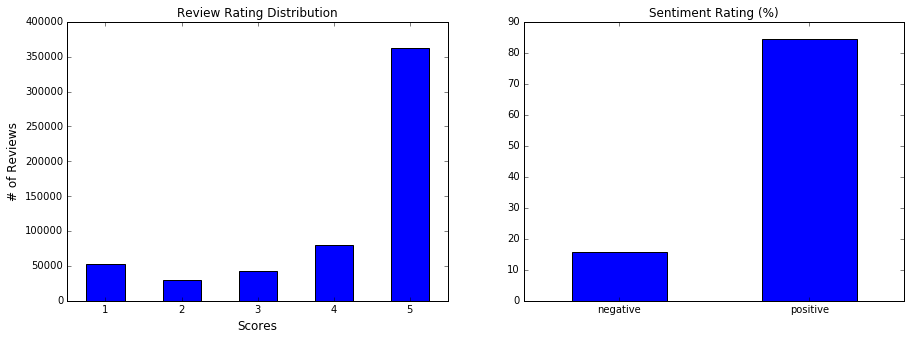

In [19]:
plt.figure(figsize=(15,5))
plt.subplot(121)
rating_count.plot(kind='bar', title='Review Rating Distribution', rot=0)
plt.xlabel('Scores', {'fontsize': 'large'})
plt.ylabel('# of Reviews', {'fontsize': 'large'})
plt.subplot(122)
ratings.plot(kind='bar', title='Sentiment Rating (%)', rot=0)
plt.show()

# Section 1: Setup 
We are going to implement two different models as classifiers for sentiment analysis: Logistic Regression (LR), and Support Vector Machine (SVM) from sci-kit learn. 

*Null hypothesis:* These two models are performing the same for sentiment analysis.


## Cleaning and transforming text data ##
We are going to use the review text as the features of sentiment classifier model. Text information is naturally unstructure data. It is difficult to fit the raw text data into most of the machine learning models which are designed efficiently for numerical operations. Hence we need to perform some text processing to conert text data to numerical representation.

Because of the large size of the dataset, we need to clean and transform the text data with the following process as part of the  feature selection and to speed up the training and predicting process.

* Changing the characters to lower case
* Removing special words (i.e. HTML tags) punctuation
* Tokenisation
* Removing pure digits which are lest significant in term of sentiment analysis
* Removing any words with length less than 3 which intend to be common (or neutral) words
* Stemming each token to its "base form" (i.e. `goes` to `go`)

In [4]:
text = """I've bought these for my husband who is currently overseas. He loves these, and apparently his staff 
likes them also.<br />There are generous amounts of Twizzlers in each 16-ounce bag, and this was well worth the price.
<a href=""http://www.amazon.com/gp/product/B001GVISJM"">Twizzlers, Strawberry, 16-Ounce Bags (Pack of 6)</a>"""
# print(nltk.tokenize.wordpunct_tokenize(text.lower()))
# print(nltk.tokenize.TreebankWordTokenizer().tokenize(text.lower()))
def word_tokenised_stemmed(text):
    text = str(text)    # convert to string
    text = text.lower()
    text = re.sub(r'<.*?>', ' ', text)
    intab = string.punctuation
    outtab = " " * len(string.punctuation)
    transtab = str.maketrans(intab, outtab)
    text = text.translate(transtab)
    tokens = nltk.tokenize.word_tokenize(text)
    stemmer = nltk.stem.PorterStemmer()
    res = [stemmer.stem(t) for t in tokens if len(t) > 2 and not t.isnumeric()]
    return res
    
print(word_tokenised_stemmed(text))
print(word_tokenised_stemmed("Hi his world"))

['bought', 'these', 'for', 'husband', 'who', 'current', 'oversea', 'love', 'these', 'and', 'appar', 'hi', 'staff', 'like', 'them', 'also', 'there', 'are', 'gener', 'amount', 'twizzler', 'each', 'ounc', 'bag', 'and', 'thi', 'wa', 'well', 'worth', 'the', 'price', 'twizzler', 'strawberri', 'ounc', 'bag', 'pack']
['hi', 'world']


## Data prepration
We are interested in the review text provided by the user as well as the score which indicates a positive or negative sentiment. We will ignore the reviews with `Score = 3` as they tend to have a neutral sentiment. 

In [5]:
print(len(food_reviews))
food_sentiments = food_reviews[food_reviews["Score"] != 3][["Score", "Text"]]

568454


In [6]:
food_sentiments["Sentiment"] = food_sentiments["Score"].apply(lambda x: "Positive" if x > 3 else "Negative")
print(len(food_sentiments))

525814


## Training and test data split

In [7]:
from sklearn.cross_validation import train_test_split, cross_val_score
X_train,X_test, y_train, y_test = train_test_split(food_sentiments['Text'], food_sentiments['Sentiment'], test_size=0.2, 
                                                   random_state=1)

## Build up pipelines for  LR and SVM models
We use the common processing tasks bag of word and TF-IDF weighted scores to transform review texts into numeric form. Then we build the pipeline for LR and SVM models.

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

lr_clf = Pipeline([('vect', CountVectorizer(analyzer=word_tokenised_stemmed)),
               ('tfidf', TfidfTransformer()),
               ('clf', LogisticRegression(C=0.1, class_weight='balanced'))
              ])

svm_clf = Pipeline([('vect', CountVectorizer(analyzer=word_tokenised_stemmed)),
                ('tfidf', TfidfTransformer()),
                ('clf', LinearSVC(C=0.1, class_weight='balanced'))])



## Using 5-fold cross validation to compare accuracy score for LR and SVM models

In [9]:
lr_scores = cross_val_score(lr_clf, X_train, y_train, cv=5, scoring='accuracy')
svm_scores = cross_val_score(svm_clf, X_train, y_train, cv=5, scoring='accuracy')

### Comparing mean and standard deviation of accuracy scores of cross validation for LR and SVM

In [65]:
# lr_scores = np.array([ 0.89099143,  0.89029014,  0.88899322,  0.8892785 ,  0.889087  ])
# svm_scores = np.array([ 0.90678822,  0.90611071,  0.90520623,  0.90654939,  0.90645318])
print("LR model accuracy score mu, sigma: {:.03f} {:.05f}".format(lr_scores.mean(), lr_scores.std()))
print("SVM model accuracy score mu, sigma: {:.03f} {:.05f}".format(svm_scores.mean(), svm_scores.std()))

LR model accuracy score mu, sigma: 0.890 0.00078
SVM model accuracy score mu, sigma: 0.906 0.00055


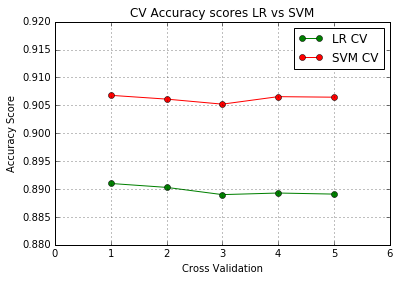

In [63]:
cv_fold = np.arange(1, 6)
# plt.figure(figsize=(7, 5))
plt.plot(cv_fold, lr_scores, "o-", color="g", label="LR CV")
plt.plot(cv_fold, svm_scores, "o-", color="r", label="SVM CV")
plt.xlim(0, 6); plt.ylim(0.88, 0.92)
plt.title("CV Accuracy scores LR vs SVM")
plt.xlabel("Cross Validation"); plt.ylabel("Accuracy Score")
plt.grid(); plt.legend()
plt.show()

### Calculate two-sided paired t-test for accuracy scores

In [20]:
from scipy import stats
print("P-value for H1 LR (mu={:.03f})and SVM (mu={:.03f}) models are not performing the same"\
      .format(lr_scores.mean(), svm_scores.mean()))
print("{:.08f}".format(stats.ttest_rel(lr_scores, svm_scores).pvalue*0.5))

P-value for H1 LR (mu=0.890)and SVM (mu=0.906) models are not performing the same
0.00000057


## Training LR and SVM models for the whole training set and making predictions on test set

In [21]:
lr_clf.fit(X_train, y_train)
svm_clf.fit(X_train, y_train)

y_pred_lr = lr_clf.predict(X_test)
y_pred_svm = svm_clf.predict(X_test)

## Evaluating accuray and f1 scores for the test set

In [24]:
print("LR classifier accuracy: {:.03f}".format(accuracy_score(y_test, y_pred_lr)))
print("SVM classifier accuracy:{:.03f}".format(accuracy_score(y_test, y_pred_svm)))
print("LR classifier f1 score: {:.03f}".format(f1_score(y_test, y_pred_lr, pos_label="Positive", average='binary')))
print("SVM classifier f1 score: {:.03f}".format(f1_score(y_test, y_pred_svm, pos_label="Positive", average='binary')))

LR classifier accuracy: 0.891
SVM classifier accuracy:0.906
LR classifier f1 score: 0.932
SVM classifier f1 score: 0.942


In [26]:
print("LR classification report: \n", classification_report(y_test, y_pred_lr))
print("\nSVM classification report: \n", classification_report(y_test, y_pred_svm))

LR classification report: 
              precision    recall  f1-score   support

   Negative       0.60      0.90      0.72     16433
   Positive       0.98      0.89      0.93     88730

avg / total       0.92      0.89      0.90    105163


SVM classification report: 
              precision    recall  f1-score   support

   Negative       0.64      0.90      0.75     16433
   Positive       0.98      0.91      0.94     88730

avg / total       0.93      0.91      0.91    105163



## What are the frequent words appearing in positive reviews?

In [44]:
lr_weights = [(f, w) for f, w in zip(lr_clf.steps[0][1].get_feature_names(), lr_clf.steps[2][1].coef_.T.tolist())]
sorted(lr_weights, key=lambda x: x[1],reverse=True)[:10]

[('great', [10.905557120270318]),
 ('best', [8.811787676748434]),
 ('delici', [8.430359589369932]),
 ('love', [8.390362816278104]),
 ('perfect', [7.647820944028153]),
 ('good', [6.48239086766923]),
 ('excel', [6.409365400304012]),
 ('nice', [5.7909471181697425]),
 ('favorit', [5.786130304184956]),
 ('highli', [5.473517173499416])]

In [45]:
svm_weights = [(f, w) for f, w in zip(svm_clf.steps[0][1].get_feature_names(), svm_clf.steps[2][1].coef_.T.tolist())]
sorted(svm_weights, key=lambda x: x[1],reverse=True)[:10]

[('great', [4.5844942031345575]),
 ('delici', [4.125527424365717]),
 ('best', [3.966381050105042]),
 ('perfect', [3.9057759652894246]),
 ('love', [3.393833110872298]),
 ('excel', [3.1707742776375873]),
 ('pleasantli', [3.118068372239215]),
 ('highli', [2.938321914929848]),
 ('skeptic', [2.930959633181658]),
 ('hook', [2.852077728913655])]

In [68]:
import pickle
with open("lr_clf.pkl", "wb") as f:
    pickle.dump(lr_clf, f)

with open("svm_clf.pkl", "wb") as f:
    pickle.dump(svm_clf, f)    